In [1]:
"""
An example of Kernel-Ridge Regression (CNN) using scikit-learn.

-pikarpov
"""

%matplotlib inline
import os
import sys
import numpy as np

sys.path.append("../../")

from sapsan.lib.backends import MLflowBackend, FakeBackend
from sapsan.lib.data import HDF5Dataset, EquidistantSampling, flatten
from sapsan.lib.estimator.krr.krr_estimator import KRR, KRRConfig
from sapsan import Train, Evaluate, model_graph

In [2]:
#--- Experiment tracking backend ---
#MLflow - the server will be launched automatically
#in case it won't, type in cmd: mlflow ui --port=9000
#uncomment tracking_backend to use mlflow

experiment_name = "KRR experiment"
tracking_backend = FakeBackend()
tracking_backend = MLflowBackend(experiment_name, host="localhost", port=9000)

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/pkarpov/anaconda3/envs/py310/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/pkarpov/anaconda3/envs/py310/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
TypeError: 'int' object is not callable


starting mlflow ui, please wait ...


[2022-08-25 16:53:17 +0100] [5931] [INFO] Starting gunicorn 20.1.0
[2022-08-25 16:53:17 +0100] [5931] [INFO] Listening at: http://127.0.0.1:9000 (5931)
[2022-08-25 16:53:17 +0100] [5931] [INFO] Using worker: sync
[2022-08-25 16:53:17 +0100] [5932] [INFO] Booting worker with pid: 5932


mlflow ui is running at localhost:9000


In [3]:
#--- Data setup ---
#In the intereset of loading and training multiple timesteps
#one can specify which checkpoints to use and where
#they appear in the path via syntax: {checkpoint:format}
#
#Next, you need to specify which features to load; let's assume 
#        path = "{feature}.h5"
#
# 1) If in different files, then specify features directly;
#    The default HDF5 label will be the last label in the file
#    Ex: features = ['velocity', 'denisty', 'pressure']
# 2) If in the same, then duplicate the name in features
#    and specify which labels to pull
#    Ex: features = ["data", "data", "data"]
#        feature_labels = ['velocity', 'density', 'pressure']

path = 'data/cnn_krr/t{checkpoint:1.0f}/{feature}_dim128_2d.h5'
features = ['u']
target = ['u']


#Dimensionality of your data in format [D,H,W]
INPUT_SIZE = [128,128]

#Reduce dimensionality to the following in format [D,H,W]
SAMPLE_TO = [64,64]

#Sampler to use for reduction
sampler = EquidistantSampling(SAMPLE_TO)

In [4]:
#Load the data
data_loader = HDF5Dataset(path=path,
                   features=features,
                   target=target,
                   checkpoints=[0],
                   input_size=INPUT_SIZE,
                   sampler=sampler, 
                   flat = True)
x, y = data_loader.load_numpy()

#ex: predict one component of the target
y = np.array([y[0]])

loaders = [x,y]

Features:  ['u']
Fetures_label: ['None']
Loading 'u00010' from file 'data/cnn_krr/t0/u_dim128_2d.h5'
----------
Sampling the input data of size (128, 128) into size [64, 64]
Loading 'u00010' from file 'data/cnn_krr/t0/u_dim128_2d.h5'
----------
Sampling the input data of size (128, 128) into size [64, 64]


/home/pkarpov/Sapsan/sapsan/examples/../../sapsan/lib/data/hdf5_dataset.py:190: UserWarning: batch_size != sampled_size. Setting the two equal.
  features_checkpoint_batch = self._get_input_data(checkpoint,


In [5]:
#Machine Learning model to use

#Configuration of the model parameters:
#    alpha - rbf kernel hyperparameter
#    gamma - rbf kernel hyperparameter
estimator = KRR(config = KRRConfig(gamma=1.778, alpha=0.001, kernel='rbf'),
                loaders = loaders)

In [6]:
#--- Train the model ---
#Set the experiment
training_experiment = Train(model = estimator,
                            backend=tracking_backend,                       
                            data_parameters = data_loader)
#Train the model
estimator = training_experiment.run()

runtime 0.7224 seconds


/home/pkarpov/anaconda3/envs/py310/lib/python3.10/site-packages/scikit_learn-1.1.2-py3.10-linux-x86_64.egg/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=4.15275e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


/home/pkarpov/Sapsan/sapsan/examples/../../sapsan/lib/data/hdf5_dataset.py:190: UserWarning: batch_size != sampled_size. Setting the two equal.
  features_checkpoint_batch = self._get_input_data(checkpoint,


Features:  ['u']
Fetures_label: ['None']
Loading 'u00010' from file 'data/cnn_krr/t0/u_dim128_2d.h5'
----------
Sampling the input data of size (128, 128) into size [64, 64]
Loading 'u00010' from file 'data/cnn_krr/t0/u_dim128_2d.h5'
----------
Sampling the input data of size (128, 128) into size [64, 64]
eval - runtime:  0.3617267608642578


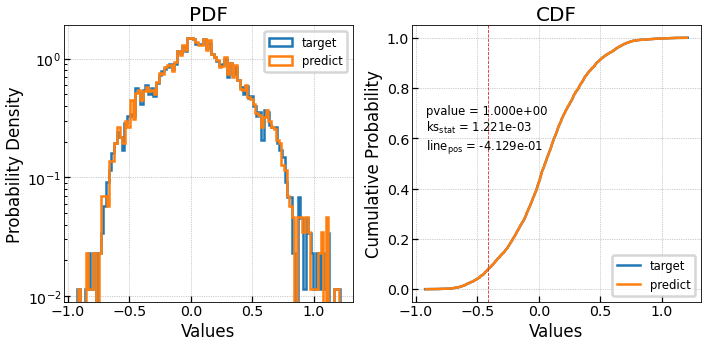

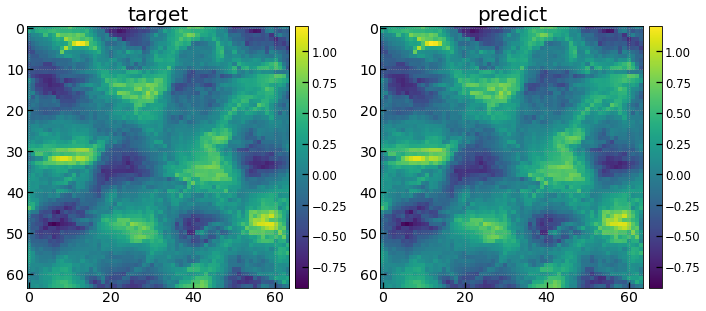

In [7]:
#--- Test the model ---
#Load the test data
data_loader = HDF5Dataset(path=path,
                   features=features,
                   target=target,
                   checkpoints=[0],
                   input_size=INPUT_SIZE,
                   sampler=sampler, 
                   flat = True)
x, y = data_loader.load_numpy()

#ex: predict one component of the target
y = np.array([y[0]])
loaders = [x,y]

#Set the test experiment
estimator.loaders = loaders
evaluation_experiment = Evaluate(model = estimator,
                                 backend=tracking_backend,
                                 data_parameters = data_loader)

#Test the model
#Evaluate() returns a dict, results = {'predict':np.ndarray, 'target':np.ndarray}
results = evaluation_experiment.run()